In [4]:
#mounting data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

In [ ]:

# Define the path to your dataset
train_dir = "drive/MyDrive/dataset/training"
test_dir = "drive/MyDrive/dataset/testing"

# Load the dataset
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    image_size=(256, 256),
    batch_size=1
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    image_size=(256, 256),
    batch_size=1
)

# Extract the training and testing data and labels
train_images, train_labels = [], []
for batch in train_data:
    train_images.append(tf.reshape(batch[0], [-1, 256, 256, 3]))
    train_labels.append(batch[1])
train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

test_images, test_labels = [], []
for batch in test_data:
    test_images.append(tf.reshape(batch[0], [-1, 256, 256, 3]))
    test_labels.append(batch[1])
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

In [ ]:
# Normalize the pixel values
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [ ]:
# Define the model
def define_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:

# Prepare data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


Found 100 files belonging to 2 classes.
Found 39 files belonging to 2 classes.
Epoch 1/20
66/66 [==============================] - 15s 207ms/step - loss: 0.7091 - accuracy: 0.4848 - precision_6: 0.5246 - recall_6: 0.8649 - auc_6: 0.3802 - val_loss: 0.7230 - val_accuracy: 0.3824 - val_precision_6: 0.3824 - val_recall_6: 1.0000 - val_auc_6: 0.6593
Epoch 2/20
66/66 [==============================] - 13s 195ms/step - loss: 0.7032 - accuracy: 0.5606 - precision_6: 0.5606 - recall_6: 1.0000 - auc_6: 0.3243 - val_loss: 0.7488 - val_accuracy: 0.3824 - val_precision_6: 0.3824 - val_recall_6: 1.0000 - val_auc_6: 0.5000
Epoch 3/20
66/66 [==============================] - 13s 202ms/step - loss: 0.6953 - accuracy: 0.4697 - precision_6: 0.5263 - recall_6: 0.5405 - auc_6: 0.4669 - val_loss: 0.7318 - val_accuracy: 0.3824 - val_precision_6: 0.3824 - val_recall_6: 1.0000 - val_auc_6: 0.5000
Epoch 4/20
66/66 [==============================] - 13s 202ms/step - loss: 0.7024 - accuracy: 0.5606 - precision_6

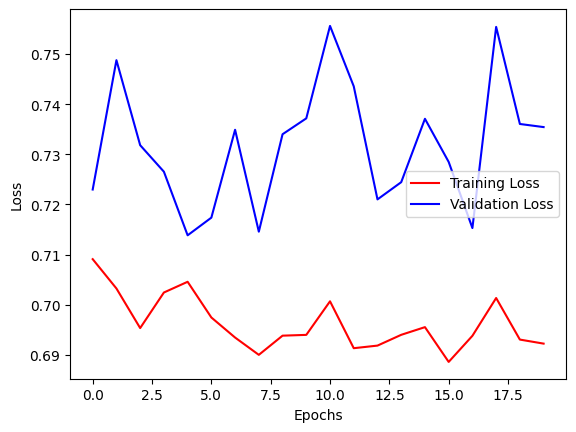

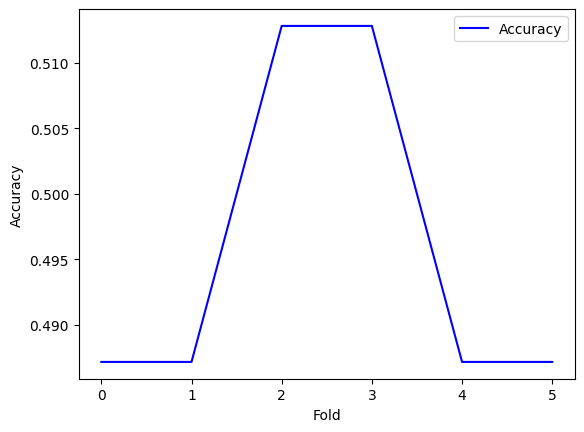

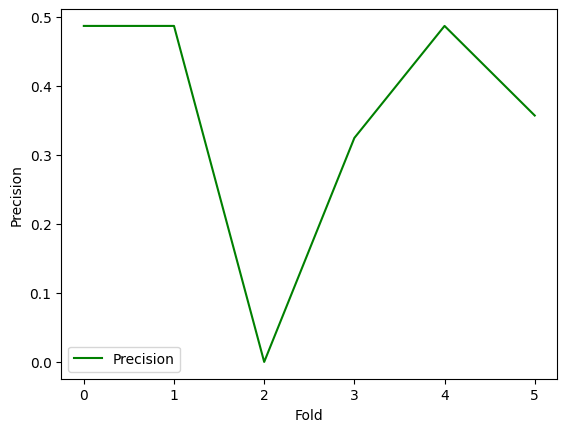

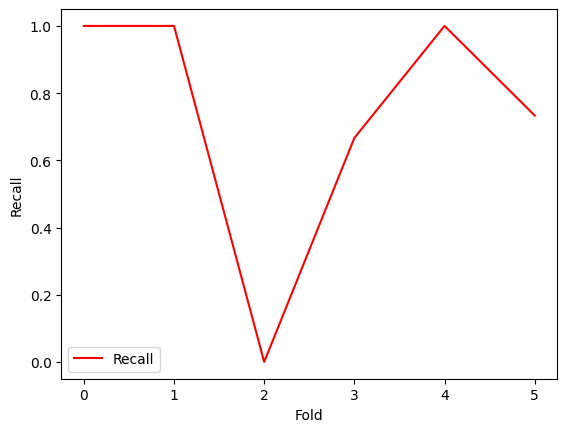

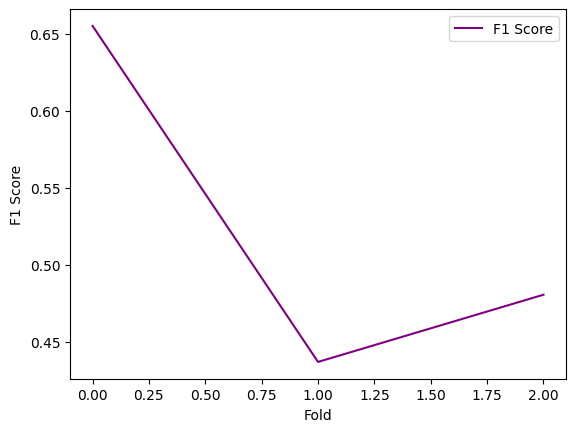

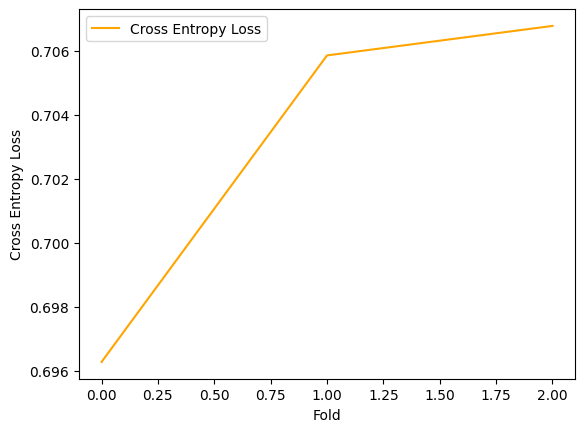

In [6]:
# Train and evaluate the model
def train_and_evaluate_model(train_images, train_labels, test_images, test_labels, n_folds=3):
    accuracy_scores, precision_scores, recall_scores, f1_scores, cross_entropy_losses = [], [], [], [], []
    histories = []

    kfold = KFold(n_folds, shuffle=True, random_state=1)
    for train_idx, test_idx in kfold.split(train_images):
        model = define_model()

        train_images_fold, train_labels_fold, test_images_fold, test_labels_fold = (
            train_images[train_idx],
            train_labels[train_idx],
            train_images[test_idx],
            train_labels[test_idx]
        )

        train_data = datagen.flow(train_images_fold, train_labels_fold, batch_size=1)
        #Compile model
        model.compile(
            optimizer=SGD(learning_rate=0.01, momentum=0.9),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )

        history = model.fit(train_data, epochs=20, batch_size=1, validation_data=(test_images_fold, test_labels_fold), verbose=1)

        evaluation_results = model.evaluate(test_images, test_labels, verbose=1)
        accuracy_scores.append(evaluation_results[1])
        precision_scores.append(evaluation_results[2])
        recall_scores.append(evaluation_results[3])

        precision = np.mean(precision_scores)
        recall = np.mean(recall_scores)
        f1 = 2 * (precision * recall) / (precision + recall)
        cross_entropy_loss = np.mean(history.history['loss'])

        print('> Accuracy:  %.3f' % (evaluation_results[1] * 100.0))
        print('> Precision:  %.3f' % (precision * 100.0))
        print('> Recall:  %.3f' % (recall * 100.0))
        print('> F1 Score:  %.3f' % (f1 * 100.0))
        print('> Cross Entropy Loss: %.3f' % cross_entropy_loss)

        accuracy_scores.append(evaluation_results[1])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        cross_entropy_losses.append(cross_entropy_loss)
        histories.append(history)
        model.summary()

        # Calculate average accuracy of folds
        avg_accuracy = np.mean(accuracy_scores)
        print('Average Accuracy: %.3f' % (avg_accuracy * 100.0))



    # Print validation metrics
    for i in range(n_folds):
        # Check available keys in history to print in validation metrics
        val_precision_keys = [key for key in histories[i].history.keys() if 'precision' in key and 'val_' in key]
        val_recall_keys = [key for key in histories[i].history.keys() if 'recall' in key and 'val_' in key]
        val_precision = np.mean([np.mean(histories[i].history[key]) for key in val_precision_keys])
        val_recall = np.mean([np.mean(histories[i].history[key]) for key in val_recall_keys])
        val_auc_keys = [key for key in histories[i].history.keys() if 'auc' in key and 'val_' in key]
        val_auc = np.mean([np.mean(histories[i].history[key]) for key in val_auc_keys])

        print("val_accuracy of fold # " + str(i+1) + " : " + str(np.mean(histories[i].history['val_accuracy'])))
        print("val_precision of fold # " + str(i+1) + " : " + str(val_precision))
        print("val_recall of fold # " + str(i+1) + " : " + str(val_recall))
        print("val_AUC of fold # " + str(i+1) + " : " + str(val_auc))
        # Calculate F1 score
        y_pred = model.predict(test_images_fold)
        y_pred = (y_pred > 0.5).astype(int)
        f1 = f1_score(test_labels_fold, y_pred)
        print("val_F1score of fold # " + str(i+1) + " : " + str(f1))

    # Graph shows the progress of the model over epochs
    plt.plot(histories[0].history['loss'], c='r')
    plt.plot(histories[0].history['val_loss'], c='b')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()


    # Plot accuracy graph
    plt.plot(accuracy_scores, color='blue', label='Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot precision graph
    plt.plot(precision_scores, color='green', label='Precision')
    plt.xlabel('Fold')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    # Plot recall graph
    plt.plot(recall_scores, color='red', label='Recall')
    plt.xlabel('Fold')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()

    # Plot F1 score graph
    plt.plot(f1_scores, color='purple', label='F1 Score')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

    # Plot cross entropy loss graph
    plt.plot(cross_entropy_losses, color='orange', label='Cross Entropy Loss')
    plt.xlabel('Fold')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.show()

# Train and evaluate the model
train_and_evaluate_model(train_images, train_labels, test_images, test_labels)


In [19]:
from tensorflow.keras import Model
def test(model, image_path):
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    resize = cv2.resize(img, (256, 256))
    plt.imshow(cv2.cvtColor(resize, cv2.COLOR_BGR2RGB))
    plt.show()

    resize_norm = resize.astype('float32') / 255.0  # Normalize the image data

    # Reshape and expand dimensions for model input
    input_image = np.expand_dims(resize_norm, axis=0)

    # Make predictions
    predictions = model.predict(input_image)
    predicted_class = "Vitiligo" if predictions[0][0] > 0.5 else "Non Vitiligo"
    confidence = predictions[0][0] * 100.0

    print("Predicted class:", predicted_class)
    print("Confidence:", confidence)

In [ ]:
from google.colab import files

# Upload an image file
uploaded = files.upload()

# Get the uploaded file path
image_path = next(iter(uploaded))

# Test the model on the uploaded image
test(model, image_path)